# Polynomial Regression for Stock Valuation with Dividend Discount Model

# Contents
* Introduction
* Dataset


# Introduction

The Dividend Discount Model is a method to calculate the fair share price of a stock. This model uses the dividend growth rate and cost of equity to calculate the fair share price of Apple stock. In this project, I implemented regression with one variable to predict the dividend growth rate. I also implemented regression to predict future stock prices. This program could be used to inform investors when to buy or sell Apple stock based on whether the stock is expected to be above or below the fair share price.

The content for this project was derived from Andrew Ng's Machine Learning course and Bekhruzbek Ochilov's Stock Valuation (using the Dividend Discount Model) from Coursera.

In [4]:
%pip install yfinance

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import math
import time
import datetime
import yfinance as yf

%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


# Dataset

**Retreiving Data**

I began by loading the raw data using the yfinance library. I then displayed the available historical data from yahoo about apple stock.

In [5]:
# Define various variables including the stock name, start and end date of data to be stored, and the interval 
ticker = "AAPL"
begin = "2013-01-02"
terminate = "2022-09-10"
period = "1wk"

apple = yf.Ticker(f"{ticker}")
hist = apple.history(start=f"{begin}", end=f"{terminate}", interval=f"{period}")
hist


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2013-01-01,17.038160,17.074463,15.850024,16.117678,1.991973e+09,0.0,0.0
2013-01-08,16.281040,16.363490,15.336562,15.436240,2.552172e+09,0.0,0.0
2013-01-15,15.330099,15.713121,14.871088,15.382400,2.494178e+09,0.0,0.0
2013-01-22,15.522691,15.843568,13.382691,13.838933,4.777452e+09,0.0,0.0
2013-01-29,14.105659,14.231795,13.598039,13.607884,2.324249e+09,0.0,0.0
...,...,...,...,...,...,...,...
2022-08-09,164.020004,173.389999,163.250000,173.190002,3.125863e+08,0.0,0.0
2022-08-16,172.779999,176.149994,167.139999,167.570007,3.375823e+08,0.0,0.0
2022-08-23,167.080002,171.050003,159.820007,161.380005,3.114818e+08,0.0,0.0


In [6]:
print(apple.info["returnOnAssets"])

0.22204


**Loading the Dataset**

I then loaded the relevant data for the task, converting these values into useful ones.
* y_train_close is the closing stock value of the corresponding date.
* x_train_close is the date of the corresponding Apple stock closing value.
* y_train_div is the dividends from the corresponding year.
* x_train_div is the year of the corresponding Apple stock dividends value.

In [7]:
# y value closing stock price dataset
df1 = hist["Close"]
y_train_close = np.array(df1)

print(len(y_train_close))

547


In [8]:
data = df1.reset_index()

x_train_close = data["Date"]

In [9]:
# store quarterly dividend data in array, luckily there is no need to account for stock splits as yahoo already does that
y_train_div_raw = np.array(apple.dividends)

raw_period = len(y_train_div_raw)
time_period = int(terminate[0:4]) - int(begin[0:4]) + 1

def get_yearly(raw_data, time):
    yearly_dataset = np.zeros(time)
    length = len(raw_data)
    for i in range(0, time):
        j = 4*i
        if j+4 > length:
            if j+3 > length:
                if j+2 > length:
                    yearly_dataset[i] = np.sum(raw_data[j:j+4]*4)
                else:
                    yearly_dataset[i] = np.sum(raw_data[j:j+4]*2)
            else:
                yearly_dataset[i] = np.sum(raw_data[j:j+4]*(4/3))
        else:
            yearly_dataset[i] = np.sum(raw_data[j:j+4])
    return yearly_dataset

y_train_div = get_yearly(y_train_div_raw, time_period)

print(y_train_div)

[0.42143    0.461429   0.5075     0.5575     0.615      0.705
 0.76       0.8075     0.865      0.90666667]


In [10]:
x_train_div = np.linspace(int(begin[0:4]), int(terminate[0:4]), time_period)

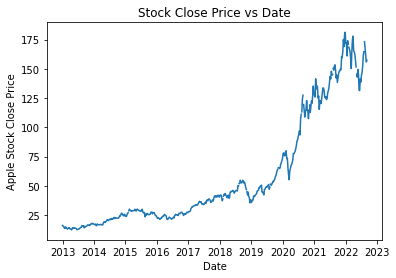

In [11]:
plt.plot(x_train_close, y_train_close) 
# Set the title
plt.title("Stock Close Price vs Date")
# Set the y-axis label
plt.ylabel("Apple Stock Close Price")
# Set the x-axis label
plt.xlabel("Date")
plt.show()

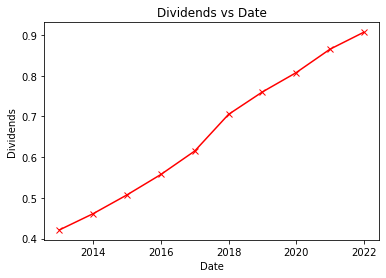

[0.42143    0.461429   0.5075     0.5575     0.615      0.705
 0.76       0.8075     0.865      0.90666667]


In [12]:
plt.plot(x_train_div, y_train_div, marker='x', c='r') 
# Set the title
plt.title("Dividends vs Date")
# Set the y-axis label
plt.ylabel("Dividends")
# Set the x-axis label
plt.xlabel("Date")
plt.show()

print(y_train_div)

In [13]:
# convert x training data for stock prices to matrix to be implemented in polynomial regression 
def Create_Matrix_Train(arr, order):
    l = len(arr)
    array = np.zeros(l)
    for i in range (l):
        date = str(arr[i])[:10]
        year = int(date[:4])
        month = int(date[5:7])
        day = int(date[-2:])
        second = int(time.mktime(datetime.datetime(year, month, day, 23, 59).timetuple()))
        array[i] = second
    length = len(array)
    matrix = []
    for j in range(length):
        for i in range(order):
            matrix.append(array[j]**(i+1))
    array = np.array(matrix).reshape((length, order))
    return array

poly_order = 6

x_train_close = Create_Matrix_Train(x_train_close, poly_order)

In [14]:
def zscore_normalize_features(X):

  # find the mean of each column/feature
  mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
  # find the standard deviation of each column/feature
  sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
  # element-wise, subtract mu for that column from each example, divide by std for that column
  X_norm = (X - mu) / sigma      
  return (X_norm, mu, sigma)

In [15]:
x_close = zscore_normalize_features(x_train_close)
x_train_close_norm = x_close[0]
x_div = zscore_normalize_features(x_train_div)
x_train_div_norm = x_div[0]

In [16]:
def compute_cost(X, y, w, b): 
    """
    compute cost
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      cost (scalar): cost
    """
    m = X.shape[0]
    cost = 0.0
    for i in range(m):                                
        f_wb_i = np.dot(X[i], w) + b           #(n,)(n,) = scalar (see np.dot)
        cost += (f_wb_i - y[i])**2       #scalar
    cost = cost / (2 * m)                      #scalar    
    return cost

In [17]:
# Compute cost with some initial values for paramaters w, b
initial_w_close = np.zeros(poly_order)
initial_w_div = 0
initial_b = 1

cost_close = compute_cost(x_train_close_norm, y_train_close, initial_w_close, initial_b)
cost_div = compute_cost(x_train_div_norm, y_train_div, initial_w_div, initial_b)

print(f'Cost at initial w: {cost_close}')
print(f'Cost at initial w: {cost_div}')

Cost at initial w: nan
Cost at initial w: 0.07100034140260557


In [18]:
def compute_gradient_poly(X, y, w, b): 
    """
    Computes the gradient for linear regression 
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar):       The gradient of the cost w.r.t. the parameter b. 
    """
    m,n = X.shape           #(number of examples, number of features)
    dj_dw = np.zeros((n,))
    dj_db = 0.

    for i in range(m):                             
        err = (np.dot(X[i], w) + b) - y[i]   
        for j in range(n):                         
            dj_dw[j] = dj_dw[j] + err * X[i, j]    
        dj_db = dj_db + err                        
    dj_dw = dj_dw / m                                
    dj_db = dj_db / m                                
        
    return dj_db, dj_dw

In [19]:
def compute_gradient_linear(x, y, w, b): 
    """
    Computes the gradient for linear regression 
    Args:
      x (ndarray): Shape (m,) Input to the model (Population of cities) 
      y (ndarray): Shape (m,) Label (Actual profits for the cities)
      w, b (scalar): Parameters of the model  
    Returns
      dj_dw (scalar): The gradient of the cost w.r.t. the parameters w
      dj_db (scalar): The gradient of the cost w.r.t. the parameter b     
     """
    
    # Number of training examples
    m = x.shape[0]
    
    # You need to return the following variables correctly
    dj_dw = 0
    dj_db = 0
    
    ### START CODE HERE ### 
    
    for i in range(m):  
        f_wb = w * x[i] + b 
        dj_dw_i = (f_wb - y[i]) * x[i] 
        dj_db_i = f_wb - y[i] 
        dj_db += dj_db_i
        dj_dw += dj_dw_i 
    dj_dw = dj_dw / m 
    dj_db = dj_db / m 

    ### END CODE HERE ### 
        
    return dj_dw, dj_db

In [20]:
# Compute and display gradient with w initialized to zeroes
initial_w_close = np.zeros(poly_order)
initial_w_div = 0
initial_b = 1

tmp_dj_dw_close, tmp_dj_db_close = compute_gradient_poly(x_train_close_norm, y_train_close, initial_w_close, initial_b)
tmp_dj_dw_div, tmp_dj_db_div = compute_gradient_linear(x_train_div_norm, y_train_div, initial_w_div, initial_b)
#tmp_dj_dw_div, tmp_dj_db_div = compute_gradient(x_train_div, y_train_div, initial_w_div, initial_b)
print('Gradient at initial w, b (zeros):', tmp_dj_dw_close, tmp_dj_db_close)
print('Gradient at initial w, b (zeros):', tmp_dj_dw_div, tmp_dj_db_div)

Gradient at initial w, b (zeros): nan [nan nan nan nan nan nan]
Gradient at initial w, b (zeros): -0.16345242584583305 0.33929743333333334


In [21]:
def gradient_descent(x, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      x :    (ndarray): Shape (m,)
      y :    (ndarray): Shape (m,)
      w_in, b_in : (scalar) Initial values of parameters of the model
      cost_function: function to compute cost
      gradient_function: function to compute the gradient
      alpha : (float) Learning rate
      num_iters : (int) number of iterations to run gradient descent
    Returns
      w : (ndarray): Shape (1,) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
    """
    
    # number of training examples
    m = len(x)
    
    # An array to store cost J and w's at each iteration — primarily for graphing later
    J_history = []
    w_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_dw, dj_db = gradient_function(x, y, w, b )  

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               
        b = b - alpha * dj_db               

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(x, y, w, b)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0:
            w_history.append(w)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w, b, J_history, w_history #return w and J,w history for graphing

In [22]:
print(x_train_div_norm)

[-1.5666989  -1.21854359 -0.87038828 -0.52223297 -0.17407766  0.17407766
  0.52223297  0.87038828  1.21854359  1.5666989 ]


In [23]:
# initialize parameters
initial_w = np.zeros(poly_order)
initial_b = 0.
# some gradient descent settings
iterations = 1000
alpha = 5.0e-7
# run gradient descent 
w_close, b_close, J_hist_close, w_hist_close = gradient_descent(x_train_close_norm, y_train_close, initial_w, initial_b, compute_cost, compute_gradient_poly, alpha, iterations)
print(f"b,w found by gradient descent: {b_close:0.2f},{w_close} ")
m,_ = x_train_close.shape
for i in range(m):
    print(f"prediction: {np.dot(x_train[i], w_close) + b_close:0.2f}, target value: {y_train[i]}")

TypeError: only size-1 arrays can be converted to Python scalars

In [24]:
# initialize fitting parameters. Recall that the shape of w is (n,)
initial_w = 0.
initial_b = 1.

# some gradient descent settings
iterations = 1500
alpha = 0.01

w_div,b_div,J_hist_div,W_hist_div = gradient_descent(x_train_div_norm, y_train_div, initial_w, initial_b, compute_cost, compute_gradient_linear, alpha, iterations)
print("w,b found by gradient descent:", w, b)

Iteration    0: Cost     0.07   
Iteration  150: Cost     0.00   
Iteration  300: Cost     0.00   
Iteration  450: Cost     0.00   
Iteration  600: Cost     0.00   
Iteration  750: Cost     0.00   
Iteration  900: Cost     0.00   
Iteration 1050: Cost     0.00   
Iteration 1200: Cost     0.00   
Iteration 1350: Cost     0.00   


NameError: name 'w' is not defined

NameError: name 'J_hist' is not defined

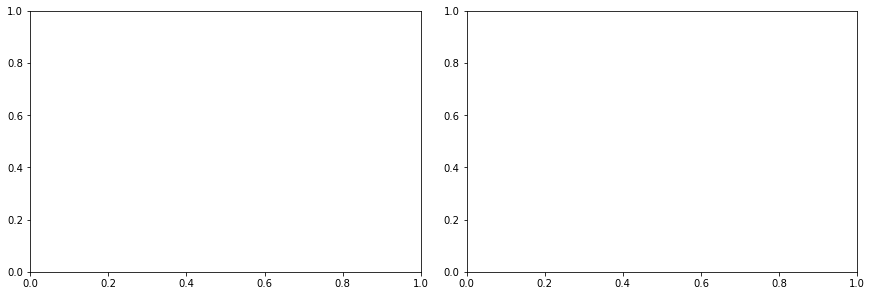

In [25]:
# plot cost versus iteration  
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_hist)
ax2.plot(100 + np.arange(len(J_hist[100:])), J_hist[100:])
ax1.set_title("Cost vs. iteration");  ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step') 
plt.show()

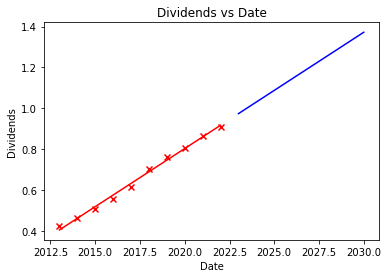

In [26]:
prediction_normalized = (w_div*x_train_div_norm)+b_div

end_predict = 2030
beg_predict = int(terminate[0:4])+1
x_predict_div = np.linspace(beg_predict, end_predict, (end_predict-beg_predict)+1)
x_predict_div_norm = (x_predict_div - x_div[1]) / x_div[2]
prediction_div = (w_div*x_predict_div_norm)+b_div





# plt.plot(x_predict_div, prediction_div, c='b') 

# plt.plot(x_train_div, prediction_normalized, c='r') 

# plt.scatter(x_train_div, y_train_div, marker='x', c='r')
# # Set the title
# plt.title("Dividends vs Date")
# # Set the y-axis label
# plt.ylabel("Dividends")
# # Set the x-axis label
# plt.xlabel("Date")
# plt.show()

In [27]:
#function to compute dividend growth rate

def growth_rate(prediction_div):
    prediction_period = len(prediction_div)
    predicted_growth = np.zeros(prediction_period-1)
    for i in range (1, prediction_period):
        predicted_growth[i-1] = prediction_div[i]/prediction_div[i-1] - 1
    return predicted_growth

[2022. 2023. 2024. 2025. 2026. 2027. 2028. 2029. 2030.]
[1.5666989  1.91485422 2.26300953 2.61116484 2.95932015 3.30747546
 3.65563078 4.00378609 4.3519414 ]
[0.91678333 0.97369014 1.03059695 1.08750377 1.14441058 1.2013174
 1.25822421 1.31513103 1.37203784]
[0.06207226 0.05844448 0.05521733 0.05232792 0.04972587 0.04737034
 0.04522788 0.04327083]


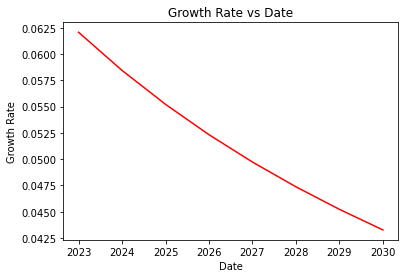

In [30]:

x_predict_div_1 = np.linspace(beg_predict-1, end_predict, (end_predict-beg_predict)+2)
x_predict_div_norm_1 = (x_predict_div_1 - x_div[1]) / x_div[2]
prediction_div_1 = (w_div*x_predict_div_norm_1)+b_div
prediction_growth = growth_rate(prediction_div_1)

print(x_predict_div_1)

print(x_predict_div_norm_1)

print(prediction_div_1)

print(prediction_growth)

plt.plot(x_predict_div, prediction_growth, c='r') 
# Set the title
plt.title("Growth Rate vs Date")
# Set the y-axis label
plt.ylabel("Growth Rate")
# Set the x-axis label
plt.xlabel("Date")
plt.show()

In [32]:
Risk_Free = 0.03

market_ticker = "VGT"

def cost_of_equity(Market_Ticker, Stock_Ticker, risk_free_rate, term):
    period = "1wk"
    VGT = yf.Ticker(f"{Market_Ticker}")
    market_hist = VGT.history(start="2005-01-01", end=f"{term}", interval=f"{period}")
    market_return = ((market_hist["Close"][-1]/market_hist["Close"][0])**(1/(int(terminate[:4])-2005)))-1
    Tick = yf.Ticker(f"{Stock_Ticker}")
    beta = Tick.info["beta"]
    cost_of_equity = risk_free_rate + (beta * (market_return - risk_free_rate))
    return cost_of_equity

cost_of_equity(market_ticker, ticker, Risk_Free, terminate)



0.16359884700975194

In [31]:
#risk free rate was 3% as of 2019
Risk_Free = 0.03

# Define various variables including the stock name, start and end date of data to be stored, and the interval 
market_ticker = "VGT"
period = "1wk"

VGT = yf.Ticker(f"{market_ticker}")
market_hist = VGT.history(start="2005-01-01", end=f"{terminate}", interval=f"{period}")
print(market_hist["Close"][-1]/market_hist["Close"][0])

print(int(terminate[:4])-2005)

market_return = ((market_hist["Close"][-1]/market_hist["Close"][0])**(1/(int(terminate[:4])-2005)))-1

beta = apple.info["beta"]

print(f"RF: {Risk_Free}")
print(f"MR: {market_return}")
print(f"beta: {beta}")








# print(ticker)
# costequity = cost_of_equity("VGT", f"{ticker}", 0.03)

# print(costequity)

9.037929033605852
17
RF: 0.03
MR: 0.1382544284706353
beta: 1.234119


In [35]:
print(prediction_div)
print(prediction_growth)



Fair_Share = (prediction_div * (prediction_growth+1))/((prediction_growth-cost_of_equity)*(-1))



print(Fair_Share)

plt.plot(x_predict_div, Fair_Share, c='r') 
# Set the title
plt.title("Dividends vs Date")
# Set the y-axis label
plt.ylabel("Dividends")
# Set the x-axis label
plt.xlabel("Date")
plt.show()

[0.97369014 1.03059695 1.08750377 1.14441058 1.2013174  1.25822421
 1.31513103 1.37203784]
[0.06207226 0.05844448 0.05521733 0.05232792 0.04972587 0.04737034
 0.04522788 0.04327083]


TypeError: unsupported operand type(s) for -: 'float' and 'function'